# Imports and dataset download

In [1]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [2]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False
IMG_SIZE = 28

In [ ]:
def get_Pendigits_dataloader(batch_size=64):
    notebook_path = os.path.abspath("autoencoder_pendigits_clustering.ipynb")
    data_path = os.path.join(os.path.dirname(notebook_path),"drive/MyDrive/Diploma/pendigits.tra")
    data = np.loadtxt(data_path, delimiter=',')
    data = np.float32(data)
    pendigits, labels = data[:, :-1], data[:, -1:]
    del data
    
    # Fix pendigits
    scaler = MinMaxScaler()
    pendigits = scaler.fit_transform(pendigits)

    # Fix labels
    labels = np.squeeze(labels)
    labels = labels.astype("int")

    # Construct the dataset and the dataloader
    tensor_pendigits = torch.Tensor(pendigits)
    data_shape = pendigits.shape[1]
    tensor_labels = torch.Tensor(labels)
    final_dataset = TensorDataset(tensor_pendigits, tensor_labels)
    dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)
    
    return dataloader, data_shape, pendigits, labels

In [ ]:
dataloader, data_shape, datapoints, labels = get_Pendigits_dataloader(batch_size=128)

In [ ]:
print(len(datapoints))

7494


# Autoencoder/Custom dataset/function declarations

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [ ]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [ ]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, hl1_neurons, hl2_neurons, latent_dimension):
        super().__init__()

        # Encoder Model
        self.input_dimension = input_dimension
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons
        self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Linear(input_dimension, self.hl1_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
        )
        
        # Latent Space
        self.latent_space = nn.Sequential(
          nn.Linear(self.hl2_neurons, self.latent_dimension),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.latent_dimension),
        )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(self.latent_dimension, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
          nn.Linear(self.hl2_neurons, self.hl1_neurons),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, input_dimension),
          nn.Sigmoid(),
        )

    def forward(self, x):
      x = self.encoder_model(x)
      x = self.latent_space(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = torch.from_numpy(x).to(device)
      x = self.encoder_model(x)
      x = self.latent_space(x)
      return x.cpu().detach().numpy()

In [ ]:
def train_autoencoder(device, dataloader, autoencoder, cluster_centroids, cluster_labels, epochs=500):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	batch_size = 128
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# Select centroids
			batch_cluster_labels = cluster_labels[low_index:high_index]
			batch_cluster_centroids = cluster_centroids[batch_cluster_labels]
			batch_cluster_centroids = torch.Tensor(batch_cluster_centroids)
			batch_cluster_centroids = Variable(batch_cluster_centroids.type(float_Tensor))
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch_cluster_centroids)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Clustering

In [ ]:
kmeans_10_clusters = KMeans(n_clusters=10, n_init=100).fit(datapoints)
retrieved_labels_10_clusters = transform_clusters_to_labels(kmeans_10_clusters.labels_, labels)

print("K_means greedy accuracy score for 10 clusters on initial space:",accuracy_score(labels, retrieved_labels_10_clusters))
print("K_means hungarian accuracy score for 10 clusters on initial space:",cluster_accuracy(labels, kmeans_10_clusters.labels_)[1])
print("K-means normalised mutual info score for 10 clusters on initial space:",normalized_mutual_info_score(labels, kmeans_10_clusters.labels_))
print("K-means ARI for 10 clusters on initial space:",adjusted_rand_score(labels, kmeans_10_clusters.labels_))
print("K-means silhouette score for 10 clusters on initial space:",silhouette_score(datapoints, kmeans_10_clusters.labels_))

K_means greedy accuracy score for 10 clusters on initial space: 0.7099012543368027
K_means hungarian accuracy score for 10 clusters on initial space: 0.7099012543368027
K-means normalised mutual info score for 10 clusters on initial space: 0.6901909018142044
K-means ARI for 10 clusters on initial space: 0.5452985827466134
K-means silhouette score for 10 clusters on initial space: 0.30624938


In [ ]:
aggloClustering_10_clusters = AgglomerativeClustering(n_clusters=10).fit(datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_10_clusters.labels_, labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(labels, aggloClustering_10_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(labels, aggloClustering_10_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(labels, aggloClustering_10_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(datapoints, aggloClustering_10_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.7516680010675206
Agglomerative clustering on initial space hungarian accuracy score: 0.7516680010675206
Normalised mutual info score on agglomerative clustering on initial space: 0.7478441807118578
Agglomerative clustering ARI on initial space: 0.6089053677623889
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.29574305


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(datapoints)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7494 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 7494 samples in 1.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7494
[t-SNE] Computed conditional probabilities for sample 2000 / 7494
[t-SNE] Computed conditional probabilities for sample 3000 / 7494
[t-SNE] Computed conditional probabilities for sample 4000 / 7494
[t-SNE] Computed conditional probabilities for sample 5000 / 7494
[t-SNE] Computed conditional probabilities for sample 6000 / 7494
[t-SNE] Computed conditional probabilities for sample 7000 / 7494
[t-SNE] Computed conditional probabilities for sample 7494 / 7494
[t-SNE] Mean sigma: 0.154407
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.041420
[t-SNE] KL divergence after 400 iterations: 1.649390


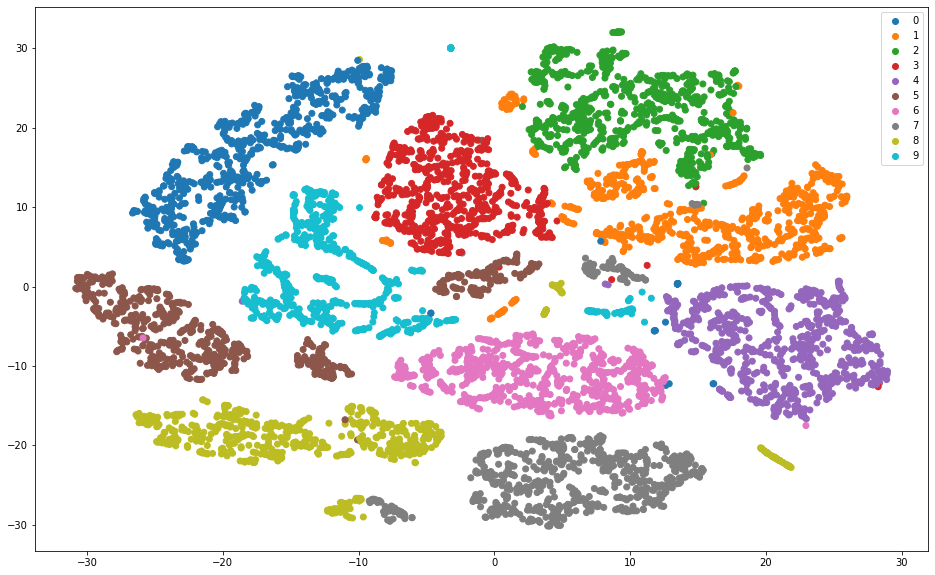

In [ ]:
dataset_labels = [0,1,2,3,4,5,6,7,8,9]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  
  for i in range(1):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    dataset_labels = [0,1,2,3,4,5,6,7,8,9]

    plt.figure(figsize=(16,10))
    scatterplot = plt.scatter(
        x=data_TSNE[:,0], y=data_TSNE[:,1],
        c=labels,
        cmap="tab10"
    )

    handles, _ = scatterplot.legend_elements(prop='colors')
    plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=10, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 10 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=10).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores]

In [ ]:
results_for_k_15 = run_experiment(15, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8542834267413931
K_means hungarian accuracy score (initial space): 0.8542834267413931
Normalised mutual info score (initial space): 0.782622301597372
ARI (initial space): 0.7233474137511655 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.055110
Epoch: 2/50, Loss: 0.037313
Epoch: 3/50, Loss: 0.031990
Epoch: 4/50, Loss: 0.028246
Epoch: 5/50, Loss: 0.024254
Epoch: 6/50, Loss: 0.020213
Epoch: 7/50, Loss: 0.016693
Epoch: 8/50, Loss: 0.013869
Epoch: 9/50, Loss: 0.011779
Epoch: 10/50, Loss: 0.010299
Epoch: 11/50, Loss: 0.009138
Epoch: 12/50, Loss: 0.008284
Epoch: 13/50, Loss: 0.007694
Epoch: 14/50, Loss: 0.007266
Epoch: 15/50, Loss: 0.006934
Epoch: 16/50, Loss: 0.006667
Epoch: 17/50, Loss: 0.006444
Epoch: 18/50, Loss: 0.006251
Epoch: 19/50, Loss: 0.006085
Epoch: 20/50, Loss: 0.005942
Epoch: 21/

In [ ]:
results_for_k_20 = run_experiment(20, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8710968775020016
K_means hungarian accuracy score (initial space): 0.8710968775020016
Normalised mutual info score (initial space): 0.8088111576624633
ARI (initial space): 0.7513001655810447 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.049184
Epoch: 2/50, Loss: 0.033028
Epoch: 3/50, Loss: 0.027894
Epoch: 4/50, Loss: 0.024372
Epoch: 5/50, Loss: 0.021325
Epoch: 6/50, Loss: 0.018643
Epoch: 7/50, Loss: 0.016228
Epoch: 8/50, Loss: 0.014160
Epoch: 9/50, Loss: 0.012362
Epoch: 10/50, Loss: 0.010894
Epoch: 11/50, Loss: 0.009872
Epoch: 12/50, Loss: 0.009168
Epoch: 13/50, Loss: 0.008655
Epoch: 14/50, Loss: 0.008242
Epoch: 15/50, Loss: 0.007900
Epoch: 16/50, Loss: 0.007611
Epoch: 17/50, Loss: 0.007369
Epoch: 18/50, Loss: 0.007129
Epoch: 19/50, Loss: 0.006777
Epoch: 20/50, Loss: 0.006354
Epoch: 21

In [ ]:
results_for_k_25 = run_experiment(25, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.88871096877502
K_means hungarian accuracy score (initial space): 0.88871096877502
Normalised mutual info score (initial space): 0.8276817376725555
ARI (initial space): 0.7864682514534302 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.066561
Epoch: 2/50, Loss: 0.046750
Epoch: 3/50, Loss: 0.038178
Epoch: 4/50, Loss: 0.032471
Epoch: 5/50, Loss: 0.027800
Epoch: 6/50, Loss: 0.023979
Epoch: 7/50, Loss: 0.020698
Epoch: 8/50, Loss: 0.017765
Epoch: 9/50, Loss: 0.015364
Epoch: 10/50, Loss: 0.013528
Epoch: 11/50, Loss: 0.012160
Epoch: 12/50, Loss: 0.011118
Epoch: 13/50, Loss: 0.010338
Epoch: 14/50, Loss: 0.009731
Epoch: 15/50, Loss: 0.009221
Epoch: 16/50, Loss: 0.008760
Epoch: 17/50, Loss: 0.008340
Epoch: 18/50, Loss: 0.007990
Epoch: 19/50, Loss: 0.007698
Epoch: 20/50, Loss: 0.007445
Epoch: 21/50,

In [ ]:
results_for_k_30 = run_experiment(30, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9039231385108086
K_means hungarian accuracy score (initial space): 0.9039231385108086
Normalised mutual info score (initial space): 0.8413230232678133
ARI (initial space): 0.8092721887977701 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.065678
Epoch: 2/50, Loss: 0.047395
Epoch: 3/50, Loss: 0.039014
Epoch: 4/50, Loss: 0.032456
Epoch: 5/50, Loss: 0.027976
Epoch: 6/50, Loss: 0.023857
Epoch: 7/50, Loss: 0.020138
Epoch: 8/50, Loss: 0.017038
Epoch: 9/50, Loss: 0.014620
Epoch: 10/50, Loss: 0.012828
Epoch: 11/50, Loss: 0.011515
Epoch: 12/50, Loss: 0.010532
Epoch: 13/50, Loss: 0.009780
Epoch: 14/50, Loss: 0.009200
Epoch: 15/50, Loss: 0.008732
Epoch: 16/50, Loss: 0.008336
Epoch: 17/50, Loss: 0.007989
Epoch: 18/50, Loss: 0.007680
Epoch: 19/50, Loss: 0.007401
Epoch: 20/50, Loss: 0.007147
Epoch: 21

In [ ]:
results_for_k_35 = run_experiment(35, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9020549773151855
K_means hungarian accuracy score (initial space): 0.9020549773151855
Normalised mutual info score (initial space): 0.843127959454585
ARI (initial space): 0.8071605802640359 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.058286
Epoch: 2/50, Loss: 0.039409
Epoch: 3/50, Loss: 0.033749
Epoch: 4/50, Loss: 0.029169
Epoch: 5/50, Loss: 0.025114
Epoch: 6/50, Loss: 0.021470
Epoch: 7/50, Loss: 0.018205
Epoch: 8/50, Loss: 0.015419
Epoch: 9/50, Loss: 0.013196
Epoch: 10/50, Loss: 0.011554
Epoch: 11/50, Loss: 0.010365
Epoch: 12/50, Loss: 0.009502
Epoch: 13/50, Loss: 0.008856
Epoch: 14/50, Loss: 0.008358
Epoch: 15/50, Loss: 0.007959
Epoch: 16/50, Loss: 0.007632
Epoch: 17/50, Loss: 0.007352
Epoch: 18/50, Loss: 0.007110
Epoch: 19/50, Loss: 0.006891
Epoch: 20/50, Loss: 0.006699
Epoch: 21/

In [ ]:
results_for_k_40 = run_experiment(40, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9214037896984254
K_means hungarian accuracy score (initial space): 0.9214037896984254
Normalised mutual info score (initial space): 0.865795614738061
ARI (initial space): 0.8420340860740071 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.066231
Epoch: 2/50, Loss: 0.046409
Epoch: 3/50, Loss: 0.037711
Epoch: 4/50, Loss: 0.032441
Epoch: 5/50, Loss: 0.027913
Epoch: 6/50, Loss: 0.024232
Epoch: 7/50, Loss: 0.021015
Epoch: 8/50, Loss: 0.018460
Epoch: 9/50, Loss: 0.016364
Epoch: 10/50, Loss: 0.014660
Epoch: 11/50, Loss: 0.013333
Epoch: 12/50, Loss: 0.012269
Epoch: 13/50, Loss: 0.011436
Epoch: 14/50, Loss: 0.010759
Epoch: 15/50, Loss: 0.010229
Epoch: 16/50, Loss: 0.009795
Epoch: 17/50, Loss: 0.009424
Epoch: 18/50, Loss: 0.009107
Epoch: 19/50, Loss: 0.008825
Epoch: 20/50, Loss: 0.008560
Epoch: 21/

In [ ]:
results_for_k_45 = run_experiment(45, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9202028289298105
K_means hungarian accuracy score (initial space): 0.9202028289298105
Normalised mutual info score (initial space): 0.8695190633000115
ARI (initial space): 0.8383872123545147 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.069527
Epoch: 2/50, Loss: 0.050261
Epoch: 3/50, Loss: 0.042004
Epoch: 4/50, Loss: 0.035870
Epoch: 5/50, Loss: 0.030011
Epoch: 6/50, Loss: 0.024829
Epoch: 7/50, Loss: 0.020225
Epoch: 8/50, Loss: 0.016459
Epoch: 9/50, Loss: 0.013594
Epoch: 10/50, Loss: 0.011582
Epoch: 11/50, Loss: 0.010174
Epoch: 12/50, Loss: 0.009226
Epoch: 13/50, Loss: 0.008548
Epoch: 14/50, Loss: 0.008055
Epoch: 15/50, Loss: 0.007665
Epoch: 16/50, Loss: 0.007346
Epoch: 17/50, Loss: 0.007078
Epoch: 18/50, Loss: 0.006842
Epoch: 19/50, Loss: 0.006639
Epoch: 20/50, Loss: 0.006448
Epoch: 21

In [ ]:
results_for_k_50 = run_experiment(50, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9278089137977048
K_means hungarian accuracy score (initial space): 0.9278089137977048
Normalised mutual info score (initial space): 0.8779364606124392
ARI (initial space): 0.8541376972233164 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.064159
Epoch: 2/50, Loss: 0.048948
Epoch: 3/50, Loss: 0.041666
Epoch: 4/50, Loss: 0.035943
Epoch: 5/50, Loss: 0.030636
Epoch: 6/50, Loss: 0.025949
Epoch: 7/50, Loss: 0.021796
Epoch: 8/50, Loss: 0.018220
Epoch: 9/50, Loss: 0.015333
Epoch: 10/50, Loss: 0.013173
Epoch: 11/50, Loss: 0.011582
Epoch: 12/50, Loss: 0.010456
Epoch: 13/50, Loss: 0.009576
Epoch: 14/50, Loss: 0.008850
Epoch: 15/50, Loss: 0.008309
Epoch: 16/50, Loss: 0.007894
Epoch: 17/50, Loss: 0.007563
Epoch: 18/50, Loss: 0.007292
Epoch: 19/50, Loss: 0.007063
Epoch: 20/50, Loss: 0.006865
Epoch: 21

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.940085401654657
K_means hungarian accuracy score (initial space): 0.940085401654657
Normalised mutual info score (initial space): 0.8976254690296822
ARI (initial space): 0.8782667879488049 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.071070
Epoch: 2/50, Loss: 0.050462
Epoch: 3/50, Loss: 0.041670
Epoch: 4/50, Loss: 0.035571
Epoch: 5/50, Loss: 0.030325
Epoch: 6/50, Loss: 0.026466
Epoch: 7/50, Loss: 0.023154
Epoch: 8/50, Loss: 0.020351
Epoch: 9/50, Loss: 0.017814
Epoch: 10/50, Loss: 0.015634
Epoch: 11/50, Loss: 0.013883
Epoch: 12/50, Loss: 0.012569
Epoch: 13/50, Loss: 0.011568
Epoch: 14/50, Loss: 0.010817
Epoch: 15/50, Loss: 0.010230
Epoch: 16/50, Loss: 0.009779
Epoch: 17/50, Loss: 0.009411
Epoch: 18/50, Loss: 0.009094
Epoch: 19/50, Loss: 0.008812
Epoch: 20/50, Loss: 0.008564
Epoch: 21/5

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 7494
[t-SNE] Computed conditional probabilities for sample 2000 / 7494
[t-SNE] Computed conditional probabilities for sample 3000 / 7494
[t-SNE] Computed conditional probabilities for sample 4000 / 7494
[t-SNE] Computed conditional probabilities for sample 5000 / 7494
[t-SNE] Computed conditional probabilities for sample 6000 / 7494
[t-SNE] Computed conditional probabilities for sample 7000 / 7494
[t-SNE] Computed conditional probabilities for sample 7494 / 7494
[t-SNE] Mean sigma: 0.151445
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.987579
[t-SNE] KL divergence after 400 iterations: 1.645299
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.8498799039231385
K-means on latent space hungarian accuracy score: 0.8498799039231385
Normalised mutual info score on k-means on latent space: 0.8060945906785131
ARI score

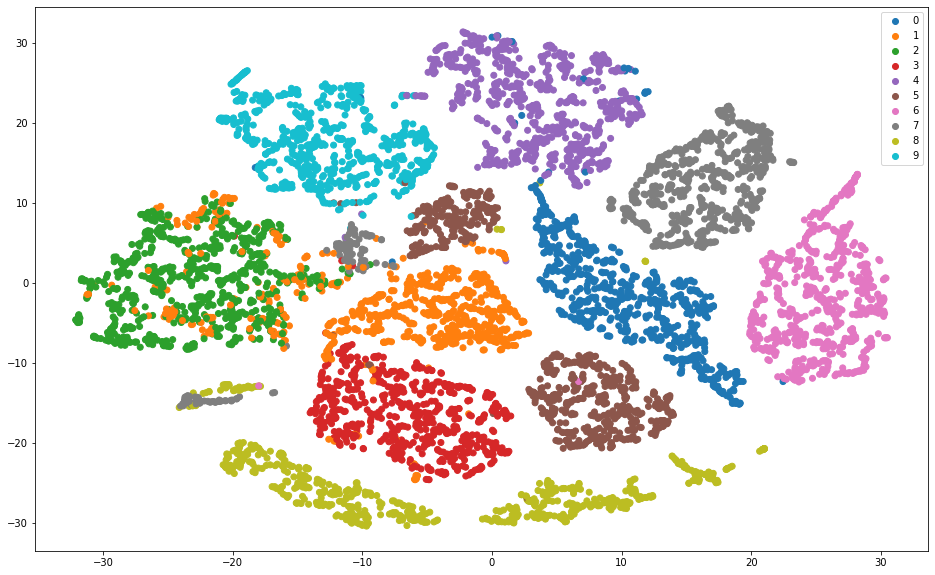

In [ ]:
results_for_k_55 = run_experiment(55, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

In [ ]:
results_for_k_60 = run_experiment(60, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

In [ ]:
kmeans_acc = np.zeros((5,10))
kmeans_NMI = np.zeros((5,10))
kmeans_ARI = np.zeros((5,10))
agglo_acc = np.zeros((5,10))
agglo_NMI = np.zeros((5,10))
agglo_ARI = np.zeros((5,10))
kmeans_silhouette = np.zeros((5,10))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_15[0][i]
  kmeans_acc[i][1] = results_for_k_20[0][i]
  kmeans_acc[i][2] = results_for_k_25[0][i]
  kmeans_acc[i][3] = results_for_k_30[0][i]
  kmeans_acc[i][4] = results_for_k_35[0][i]
  kmeans_acc[i][5] = results_for_k_40[0][i]
  kmeans_acc[i][6] = results_for_k_45[0][i]
  kmeans_acc[i][7] = results_for_k_50[0][i]
  kmeans_acc[i][8] = results_for_k_55[0][i]
  kmeans_acc[i][9] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_15[1][i]
  kmeans_NMI[i][1] = results_for_k_20[1][i]
  kmeans_NMI[i][2] = results_for_k_25[1][i]
  kmeans_NMI[i][3] = results_for_k_30[1][i]
  kmeans_NMI[i][4] = results_for_k_35[1][i]
  kmeans_NMI[i][5] = results_for_k_40[1][i]
  kmeans_NMI[i][6] = results_for_k_45[1][i]
  kmeans_NMI[i][7] = results_for_k_50[1][i]
  kmeans_NMI[i][8] = results_for_k_55[1][i]
  kmeans_NMI[i][9] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_15[2][i]
  kmeans_ARI[i][1] = results_for_k_20[2][i]
  kmeans_ARI[i][2] = results_for_k_25[2][i]
  kmeans_ARI[i][3] = results_for_k_30[2][i]
  kmeans_ARI[i][4] = results_for_k_35[2][i]
  kmeans_ARI[i][5] = results_for_k_40[2][i]
  kmeans_ARI[i][6] = results_for_k_45[2][i]
  kmeans_ARI[i][7] = results_for_k_50[2][i]
  kmeans_ARI[i][8] = results_for_k_55[2][i]
  kmeans_ARI[i][9] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_15[3][i]
  agglo_acc[i][1] = results_for_k_20[3][i]
  agglo_acc[i][2] = results_for_k_25[3][i]
  agglo_acc[i][3] = results_for_k_30[3][i]
  agglo_acc[i][4] = results_for_k_35[3][i]
  agglo_acc[i][5] = results_for_k_40[3][i]
  agglo_acc[i][6] = results_for_k_45[3][i]
  agglo_acc[i][7] = results_for_k_50[3][i]
  agglo_acc[i][8] = results_for_k_55[3][i]
  agglo_acc[i][9] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_15[4][i]
  agglo_NMI[i][1] = results_for_k_20[4][i]
  agglo_NMI[i][2] = results_for_k_25[4][i]
  agglo_NMI[i][3] = results_for_k_30[4][i]
  agglo_NMI[i][4] = results_for_k_35[4][i]
  agglo_NMI[i][5] = results_for_k_40[4][i]
  agglo_NMI[i][6] = results_for_k_45[4][i]
  agglo_NMI[i][7] = results_for_k_50[4][i]
  agglo_NMI[i][8] = results_for_k_55[4][i]
  agglo_NMI[i][9] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_15[5][i]
  agglo_ARI[i][1] = results_for_k_20[5][i]
  agglo_ARI[i][2] = results_for_k_25[5][i]
  agglo_ARI[i][3] = results_for_k_30[5][i]
  agglo_ARI[i][4] = results_for_k_35[5][i]
  agglo_ARI[i][5] = results_for_k_40[5][i]
  agglo_ARI[i][6] = results_for_k_45[5][i]
  agglo_ARI[i][7] = results_for_k_50[5][i]
  agglo_ARI[i][8] = results_for_k_55[5][i]
  agglo_ARI[i][9] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_15[6][i]
  kmeans_silhouette[i][1] = results_for_k_20[6][i]
  kmeans_silhouette[i][2] = results_for_k_25[6][i]
  kmeans_silhouette[i][3] = results_for_k_30[6][i]
  kmeans_silhouette[i][4] = results_for_k_35[6][i]
  kmeans_silhouette[i][5] = results_for_k_40[6][i]
  kmeans_silhouette[i][6] = results_for_k_45[6][i]
  kmeans_silhouette[i][7] = results_for_k_50[6][i]
  kmeans_silhouette[i][8] = results_for_k_55[6][i]
  kmeans_silhouette[i][9] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

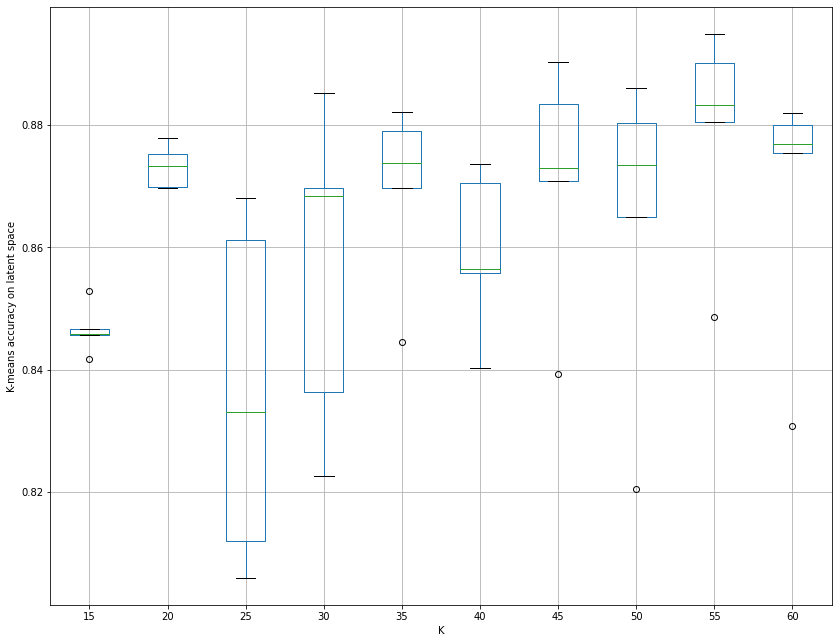

In [ ]:
columns = ['15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

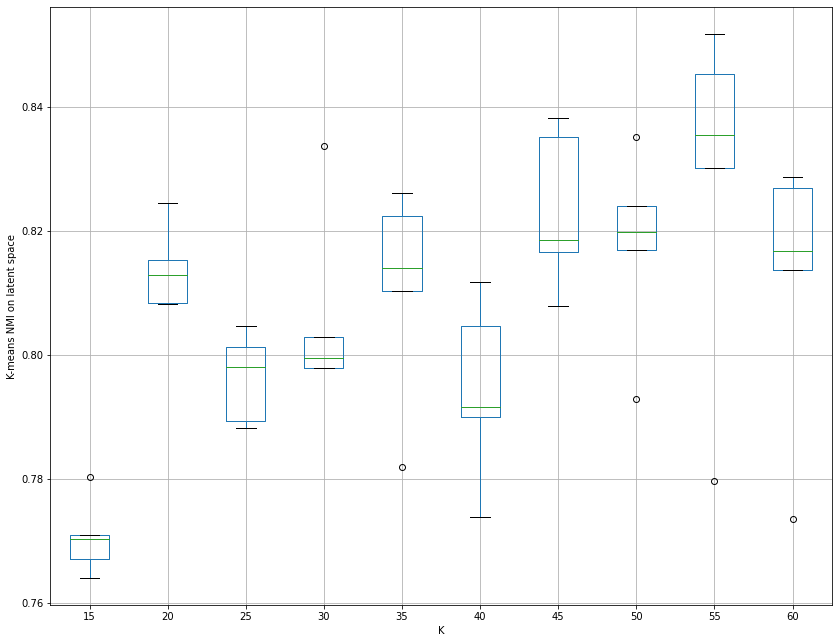

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

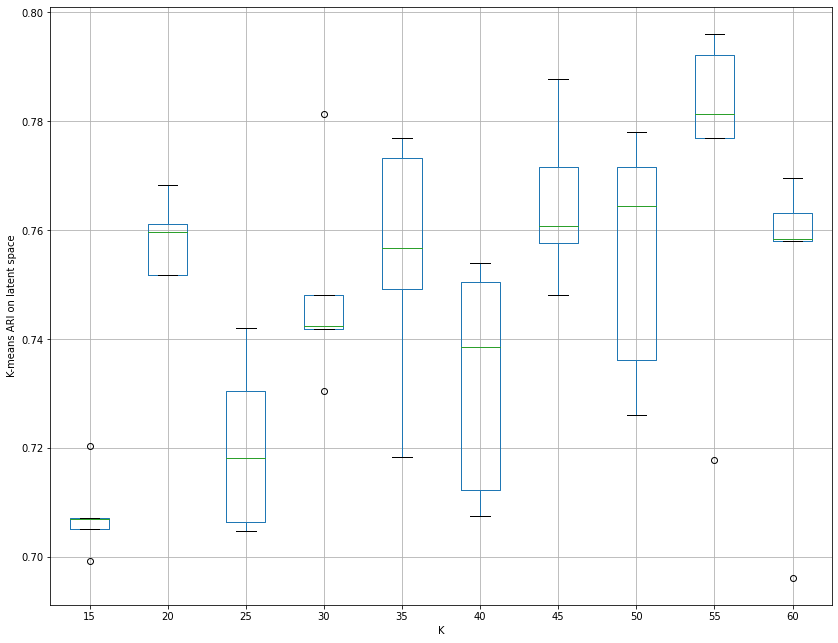

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

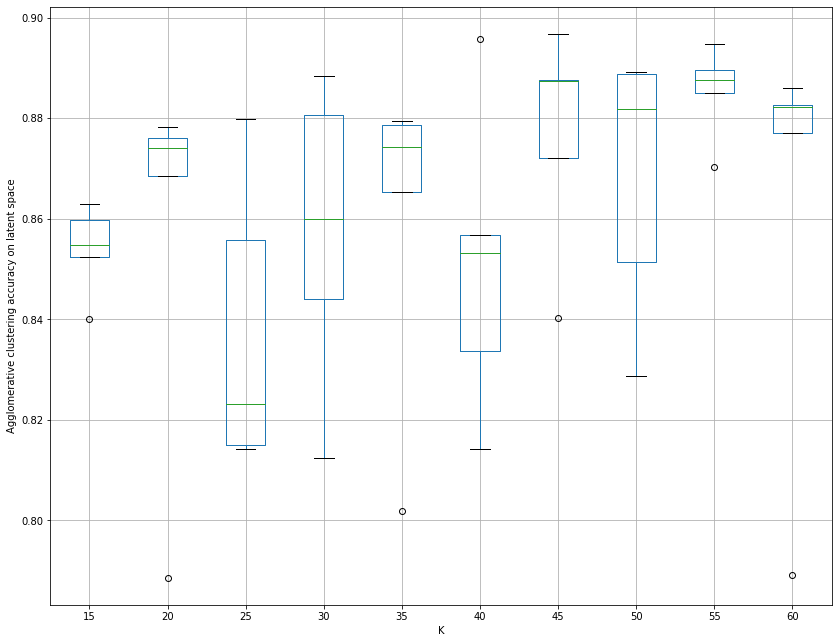

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

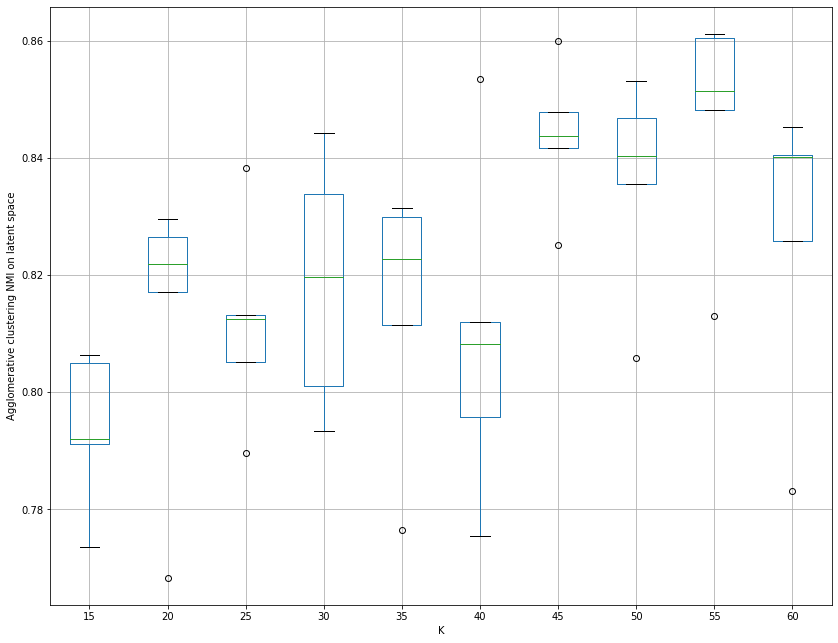

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

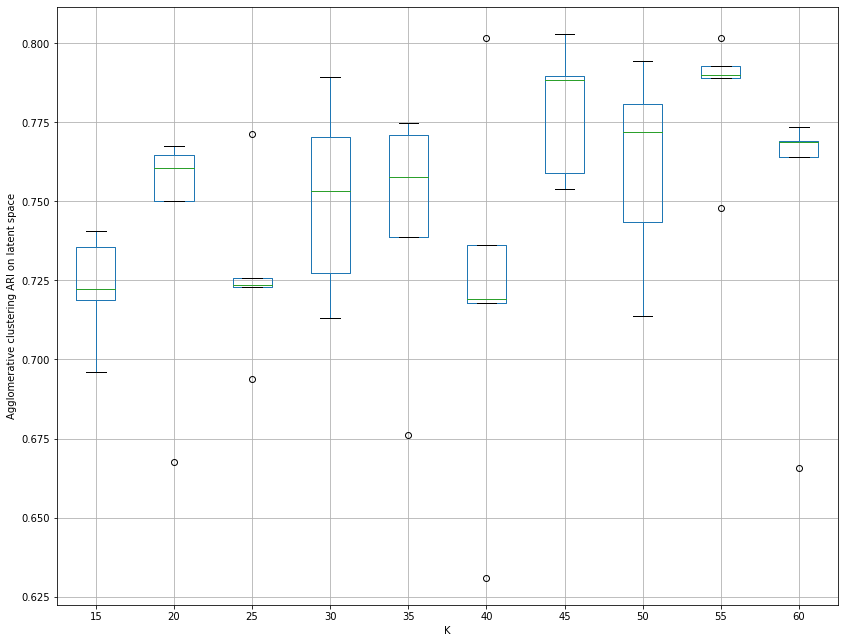

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

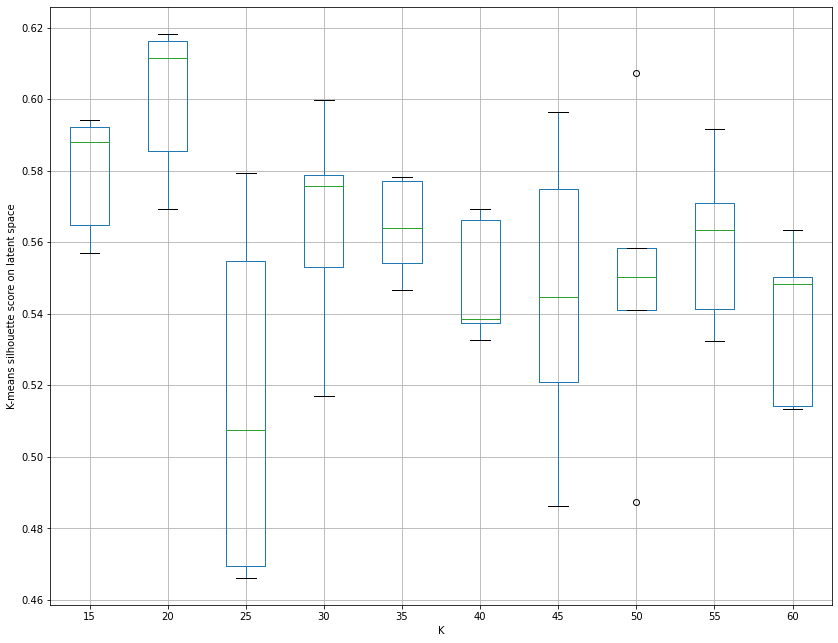

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')

# Silhoutte factor

In [ ]:
def get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):

  representation_K_tuples = []

  for K in list_of_cluster_numbers:
    print("Creating representation for K =", K, ":\n")
    print("Running k-means...\n")
    kmeans = KMeans(n_clusters=K, n_init=100).fit(datapoints)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # using the autoencoder model on our data

    print("Training autoencoder...\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    print("\n")
    latent_data = autoencoder.encoder(datapoints, device)
    r = latent_data

    representation_K_tuples.append((r,K))

  return representation_K_tuples


In [ ]:
def calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers):
  representations = [pair[0] for pair in representation_tuples]
  rep_silhouette_list = [[] for i in range(len(representations))]

  for index, rep in enumerate(representations):
    print("Starting process for representation number", index + 1,":\n")
    for K in list_of_cluster_numbers:
      print("Running kmeans for K =", K,"...")
      kmeans = KMeans(n_clusters=K, n_init=100).fit(rep)
      k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
      rep_silhouette_list[index].append(k_means_silhouette_score)
    print("\n")

  return rep_silhouette_list

In [ ]:
def get_max_silhouette_for_each_representation(rep_silhouette_lst):
  max_silhouette_tuples = [] # keep tuples in the form of (index, max_silhouette)

  for index, silhouette_lst in enumerate(rep_silhouette_lst):
    max = silhouette_lst[0]

    for i in range(1,len(silhouette_lst)):
        if silhouette_lst[i] > max:
            max = silhouette_lst[i]

    max_silhouette_tuples.append((index, max))

  return max_silhouette_tuples

In [ ]:
def calculate_representation_kmeans_acc(representation_tuples, Y):
  representations = [pair[0] for pair in representation_tuples]
  accuracies = []

  for index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=10, n_init=100).fit(rep)
    kmeans_clusters = kmeans.labels_
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, Y)
    acc = accuracy_score(Y, kmeans_greedy_labels)
    accuracies.append((index,acc))

  return accuracies

In [ ]:
def calculate_normalised_silhouette(max_silhouette_tuples, representation_tuples):
  normalised_silhouette_tuples = []
  representations = [pair[0] for pair in representation_tuples]

  for rep_index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=10, n_init=100).fit(rep)
    k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
    normalised_silhouette = (k_means_silhouette_score) / (max_silhouette_tuples[rep_index][1])
    normalised_silhouette_tuples.append((rep_index, normalised_silhouette))


  return normalised_silhouette_tuples

In [ ]:
def silhouette_factor(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):
  representation_tuples = get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers)
  representation_silhouette_list = calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers)
  max_silhouette_list = get_max_silhouette_for_each_representation(representation_silhouette_list)
  normalised_silhouette_scores = calculate_normalised_silhouette(max_silhouette_list,representation_tuples)
  k_means_accuracies = calculate_representation_kmeans_acc(representation_tuples, labels)
  print(normalised_silhouette_scores)
  print(k_means_accuracies)

  return normalised_silhouette_scores, k_means_accuracies

In [ ]:
normalised_silhouette_scores, k_means_accuracies = silhouette_factor(dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8, list_of_cluster_numbers=[15,20,25,30,35,40,45,50,55,60])

Creating representation for K = 15 :

Running k-means...

Training autoencoder...

Epoch: 1/50, Loss: 0.041274
Epoch: 2/50, Loss: 0.030825
Epoch: 3/50, Loss: 0.028065
Epoch: 4/50, Loss: 0.025050
Epoch: 5/50, Loss: 0.021724
Epoch: 6/50, Loss: 0.018193
Epoch: 7/50, Loss: 0.015026
Epoch: 8/50, Loss: 0.012442
Epoch: 9/50, Loss: 0.010491
Epoch: 10/50, Loss: 0.009102
Epoch: 11/50, Loss: 0.008145
Epoch: 12/50, Loss: 0.007465
Epoch: 13/50, Loss: 0.006952
Epoch: 14/50, Loss: 0.006534
Epoch: 15/50, Loss: 0.006188
Epoch: 16/50, Loss: 0.005909
Epoch: 17/50, Loss: 0.005679
Epoch: 18/50, Loss: 0.005479
Epoch: 19/50, Loss: 0.005303
Epoch: 20/50, Loss: 0.005147
Epoch: 21/50, Loss: 0.005008
Epoch: 22/50, Loss: 0.004881
Epoch: 23/50, Loss: 0.004765
Epoch: 24/50, Loss: 0.004660
Epoch: 25/50, Loss: 0.004563
Epoch: 26/50, Loss: 0.004474
Epoch: 27/50, Loss: 0.004390
Epoch: 28/50, Loss: 0.004313
Epoch: 29/50, Loss: 0.004240
Epoch: 30/50, Loss: 0.004168
Epoch: 31/50, Loss: 0.004096
Epoch: 32/50, Loss: 0.00402

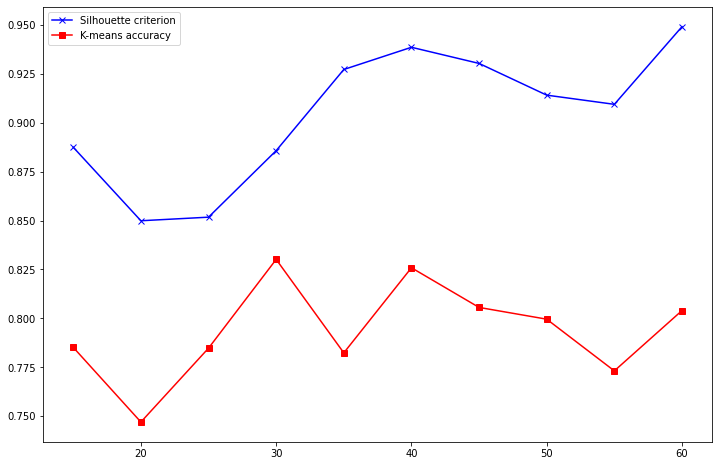

In [ ]:
list_of_cluster_numbers=[15,20,25,30,35,40,45,50,55,60]

normalised_silhouette_scores = [t[1] for t in normalised_silhouette_scores]
k_means_accuracies = [t[1] for t in k_means_accuracies]

plt.figure(figsize=(12, 8))
plt.plot(list_of_cluster_numbers, normalised_silhouette_scores, c='b', marker='x', label='Silhouette criterion')
plt.plot(list_of_cluster_numbers, k_means_accuracies, c='r', marker='s', label='K-means accuracy')
plt.legend(loc='upper left')
plt.show()